In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import pandas_profiling
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _r

In [2]:
telecom_data= pd.read_csv("telecom_churn_data.csv")

In [3]:
telecom_data.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [4]:
columns1 = ['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_data_6','total_rech_data_7','total_rech_data_8']

In [5]:
telecom_data[columns1].head()

av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  \
0               252.0               252.0               252.0   
1                 NaN               154.0                50.0   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                56.0                 NaN                 NaN   

   total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_rech_data_6  \
0               362               252               252                1.0   
1                74               384               283                NaN   
2               168               315               116                NaN   
3               230               310               601                NaN   
4               196               350               287                1.0   

   total_rech_data_7  total_rech_data_8  
0                1.0                1.0  
1                1.0                2.0  
2                NaN                NaN  
3                NaN                NaN  
4                NaN                NaN

### Filter high-value customers

In [6]:
#replacing null
telecom_data[['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_num_9','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9']] = telecom_data[['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_num_9','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9']].replace(np.nan, 0, regex=True)

    We can do countofdata* avgdata = total_data
        Total_data + total_rech

In [7]:
telecom_data['total_rech_amt_data_6'] = telecom_data.apply(lambda x: (x['total_rech_data_6']*x['av_rech_amt_data_6']),axis =1)

In [8]:
telecom_data['total_rech_amt_data_7'] = telecom_data.apply(lambda x: (x['total_rech_data_7']*x['av_rech_amt_data_7']),axis =1)

In [9]:
telecom_data['avg_rech_amt_6_7'] = telecom_data.apply(lambda x: ((x['total_rech_amt_6']+x['total_rech_amt_7']+x['total_rech_amt_data_6']+x['total_rech_amt_data_7'])/2),axis =1)

In [10]:
telecom_data['avg_rech_decile'] = pd.qcut(telecom_data['avg_rech_amt_6_7'], 10, labels=False)

In [11]:
telecom_data[['mobile_number','avg_rech_decile']].head()

mobile_number  avg_rech_decile
0     7000842753                7
1     7001865778                5
2     7001625959                4
3     7001204172                4
4     7000142493                5

In [12]:
telecom_data_high_value = telecom_data[telecom_data.avg_rech_decile >6 ]

In [13]:
telecom_data_high_value[['mobile_number','avg_rech_decile']].head()

mobile_number  avg_rech_decile
0      7000842753                7
7      7000701601                9
8      7001524846                8
21     7002124215                7
23     7000887461                7

In [14]:
telecom_data_high_value.count().head()

mobile_number     29953
circle_id         29953
loc_og_t2o_mou    29730
std_og_t2o_mou    29730
loc_ic_t2o_mou    29730
dtype: int64

In [15]:
telecom_data_high_value.to_csv('telecom_data_high_value.csv')

In [16]:
#pandas_profiling.ProfileReport(telecom_data_high_value)

### Data Preprocessing

In [17]:
telecom_data_high_value['loc_ic_t2o_mou'].nunique()

1

In [18]:
telecom_data_high_value[ 'std_og_t2o_mou'].nunique()

1

In [19]:
telecom_data_high_value['loc_og_t2o_mou'].nunique()

1

In [20]:
telecom_data_high_value['circle_id'].nunique()

1

In [21]:
telecom_data_high_value.drop(['loc_ic_t2o_mou','std_og_t2o_mou','loc_og_t2o_mou','circle_id'], axis =1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
telecom_data_high_value['last_date_of_month_6'] = pd.to_datetime('6/30/2014', format='%m/%d/%Y')
telecom_data_high_value['last_date_of_month_7'] = pd.to_datetime('7/31/2014', format='%m/%d/%Y')
telecom_data_high_value['last_date_of_month_8'] = pd.to_datetime('8/31/2014', format='%m/%d/%Y')
telecom_data_high_value['last_date_of_month_9'] = pd.to_datetime('9/30/2014', format='%m/%d/%Y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [23]:
telecom_data_high_value.filter(regex='arpu_').isnull().any()

arpu_6       False
arpu_7       False
arpu_8       False
arpu_9       False
arpu_3g_6     True
arpu_3g_7     True
arpu_3g_8     True
arpu_3g_9     True
arpu_2g_6     True
arpu_2g_7     True
arpu_2g_8     True
arpu_2g_9     True
dtype: bool

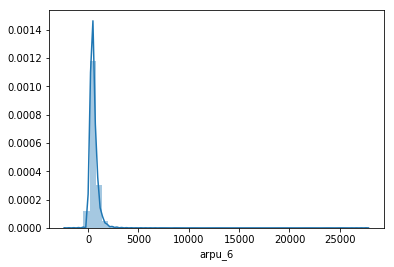

In [24]:
sns.distplot(telecom_data_high_value['arpu_6'])
plt.show()

In [25]:
##Add 3g + 2G after missing value
#replacing null
telecom_data_high_value[['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8', 'arpu_2g_9']] = telecom_data_high_value[['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8', 'arpu_2g_9']].replace(np.nan, 0, regex=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [26]:
telecom_data_high_value['arpu_2g_3g_6'] = telecom_data_high_value.apply(lambda x: (x['arpu_3g_6']+x['arpu_2g_6']),axis =1)
telecom_data_high_value.drop(['arpu_3g_6','arpu_2g_6'],axis=1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
telecom_data_high_value['arpu_2g_3g_7'] = telecom_data_high_value.apply(lambda x: (x['arpu_3g_7']+x['arpu_2g_7']),axis =1)
telecom_data_high_value.drop(['arpu_3g_7','arpu_2g_7'],axis=1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
telecom_data_high_value['arpu_2g_3g_8'] = telecom_data_high_value.apply(lambda x: (x['arpu_3g_8']+x['arpu_2g_8']),axis =1)
telecom_data_high_value.drop(['arpu_3g_8','arpu_2g_8'],axis=1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
columns_net = telecom_data_high_value.filter(regex='net_').columns

In [30]:
telecom_data_high_value[columns_net] = telecom_data_high_value[columns_net].replace(np.nan, 0, regex=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


#### Frequency

In [31]:
def churnfreq(telecom_data_high_value):
    i = 0
    a = np.where(telecom_data_high_value[['date_of_last_rech_6']].isnull(),0,1)
    i = i+a
    b = np.where(telecom_data_high_value[['date_of_last_rech_7']].isnull(),0,1)
    i=i+b
    c = np.where(telecom_data_high_value[['date_of_last_rech_8']].isnull(),0,1)
    i=i+c
    d = np.where(telecom_data_high_value[['date_of_last_rech_9']].isnull(),0,1)
    i=i+d
    return i

In [32]:
telecom_data_high_value['Frequency'] = 0
telecom_data_high_value['Frequency'] = telecom_data_high_value.apply(churnfreq, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
telecom_data_high_value['Frequency']

0        4
7        4
8        4
21       4
23       4
33       4
38       4
41       4
48       4
53       4
56       4
57       4
61       4
67       3
69       4
73       4
77       4
86       4
87       4
91       3
92       4
96       4
101      4
102      4
103      4
104      4
105      4
111      4
115      4
124      4
        ..
99896    4
99899    4
99902    4
99903    4
99904    4
99921    4
99922    4
99923    3
99924    4
99925    4
99927    4
99929    4
99931    4
99935    4
99937    4
99939    4
99941    4
99942    4
99947    4
99955    4
99957    4
99959    4
99963    4
99965    4
99970    4
99981    3
99984    4
99986    4
99988    4
99997    4
Name: Frequency, Length: 29953, dtype: int32

In [34]:
telecom_data_high_value[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','Frequency']][telecom_data_high_value.date_of_last_rech_7.isnull() == True].head()

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
603             6/7/2014                 NaN                 NaN   
679            6/29/2014                 NaN           8/24/2014   
1374           6/27/2014                 NaN           8/25/2014   
1555           6/21/2014                 NaN                 NaN   
2777           6/17/2014                 NaN           8/28/2014   

     date_of_last_rech_9  Frequency  
603             9/5/2014          2  
679                  NaN          2  
1374           9/29/2014          3  
1555                 NaN          1  
2777                 NaN          2

#### Recency -

In [35]:
telecom_data_high_value['date_of_last_rech_8'].unique()

array(['8/8/2014', '8/26/2014', '8/30/2014', '8/31/2014', '8/24/2014',
       '8/28/2014', '8/23/2014', '8/2/2014', '8/27/2014', '8/21/2014',
       '8/29/2014', '8/25/2014', '8/17/2014', '8/22/2014', '8/19/2014',
       nan, '8/15/2014', '8/9/2014', '8/20/2014', '8/1/2014', '8/6/2014',
       '8/10/2014', '8/16/2014', '8/12/2014', '8/7/2014', '8/11/2014',
       '8/13/2014', '8/18/2014', '8/5/2014', '8/14/2014', '8/3/2014',
       '8/4/2014'], dtype=object)

In [36]:
telecom_data_high_value[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']] = telecom_data_high_value[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']].replace('-', '/', regex=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [37]:
telecom_data_high_value['date_of_last_rech_8'].unique()

array(['8/8/2014', '8/26/2014', '8/30/2014', '8/31/2014', '8/24/2014',
       '8/28/2014', '8/23/2014', '8/2/2014', '8/27/2014', '8/21/2014',
       '8/29/2014', '8/25/2014', '8/17/2014', '8/22/2014', '8/19/2014',
       nan, '8/15/2014', '8/9/2014', '8/20/2014', '8/1/2014', '8/6/2014',
       '8/10/2014', '8/16/2014', '8/12/2014', '8/7/2014', '8/11/2014',
       '8/13/2014', '8/18/2014', '8/5/2014', '8/14/2014', '8/3/2014',
       '8/4/2014'], dtype=object)

In [38]:
telecom_data_high_value['date_of_last_rech_6'] = pd.to_datetime(telecom_data_high_value['date_of_last_rech_6'], format='%m/%d/%Y')
telecom_data_high_value['date_of_last_rech_7'] = pd.to_datetime(telecom_data_high_value['date_of_last_rech_7'], format='%m/%d/%Y')
telecom_data_high_value['date_of_last_rech_8'] = pd.to_datetime(telecom_data_high_value['date_of_last_rech_8'], format='%m/%d/%Y')
telecom_data_high_value['date_of_last_rech_9'] = pd.to_datetime(telecom_data_high_value['date_of_last_rech_9'], format='%m/%d/%Y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [39]:
telecom_data_high_value['last_date_of_month_6'] = pd.to_datetime('6/30/2014', format='%m/%d/%Y')
telecom_data_high_value['last_date_of_month_7'] = pd.to_datetime('7/31/2014', format='%m/%d/%Y')
telecom_data_high_value['last_date_of_month_8'] = pd.to_datetime('8/31/2014', format='%m/%d/%Y')
telecom_data_high_value['last_date_of_month_9'] = pd.to_datetime('9/30/2014', format='%m/%d/%Y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [40]:
def churnrec(telecom_data_high_value):
    k=True
    a = np.where(telecom_data_high_value[['date_of_last_rech_9']].isnull(),0,1)
    b = np.where(telecom_data_high_value[['date_of_last_rech_8']].isnull(),0,1)
    c = np.where(telecom_data_high_value[['date_of_last_rech_7']].isnull(),0,1)
    d = np.where(telecom_data_high_value[['date_of_last_rech_6']].isnull(),0,1)
    while True:
        if a == 1:
            no_of_Days = (telecom_data_high_value['last_date_of_month_9']  - telecom_data_high_value['date_of_last_rech_9'])
            break
        elif b == 1:
            no_of_Days = (telecom_data_high_value['last_date_of_month_9']  - telecom_data_high_value['date_of_last_rech_8'])
            break
        elif c == 1:
            no_of_Days = (telecom_data_high_value['last_date_of_month_9']  - telecom_data_high_value['date_of_last_rech_7'])
            break
        elif d == 1:
            no_of_Days = (telecom_data_high_value['last_date_of_month_9']  - telecom_data_high_value['date_of_last_rech_6'])
            break
    return no_of_Days

In [41]:
telecom_data_high_value['Recency'] = telecom_data_high_value.apply(churnrec, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
telecom_data_high_value[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','Recency','Frequency']][telecom_data_high_value.date_of_last_rech_7.isnull() == True].head(20)

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
603            2014-06-07                 NaT                 NaT   
679            2014-06-29                 NaT          2014-08-24   
1374           2014-06-27                 NaT          2014-08-25   
1555           2014-06-21                 NaT                 NaT   
2777           2014-06-17                 NaT          2014-08-28   
3757           2014-06-29                 NaT          2014-08-26   
4190           2014-06-14                 NaT                 NaT   
4960           2014-06-23                 NaT                 NaT   
5327           2014-06-16                 NaT                 NaT   
7012           2014-06-21                 NaT                 NaT   
7304           2014-06-24                 NaT          2014-08-28   
7662           2014-06-14                 NaT          2014-08-30   
7984           2014-06-18                 NaT                 NaT   
8979           2014-06-22                 NaT          2014-08-25   
12127          2014-06-27                 NaT          2014-08-26   
12414          2014-06-23                 NaT          2014-08-17   
12428          2014-06-28                 NaT          2014-08-01   
13864          2014-06-30                 NaT                 NaT   
14039          2014-06-24                 NaT                 NaT   
14191          2014-06-30                 NaT          2014-08-31   

      date_of_last_rech_9  Recency  Frequency  
603            2014-09-05  25 days          2  
679                   NaT  37 days          2  
1374           2014-09-29   1 days          3  
1555                  NaT 101 days          1  
2777                  NaT  33 days          2  
3757           2014-09-30   0 days          3  
4190                  NaT 108 days          1  
4960                  NaT  99 days          1  
5327                  NaT 106 days          1  
7012           2014-09-13  17 days          2  
7304           2014-09-20  10 days          3  
7662           2014-09-13  17 days          3  
7984                  NaT 104 days          1  
8979           2014-09-29   1 days          3  
12127          2014-09-30   0 days          3  
12414                 NaT  44 days          2  
12428          2014-09-11  19 days          3  
13864                 NaT  92 days          1  
14039          2014-09-29   1 days          2  
14191          2014-09-25   5 days          3

#### Monetary

In [43]:
telecom_data_high_value[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9']] = telecom_data_high_value[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9']].replace(np.nan, 0, regex=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [44]:
telecom_data_high_value['Monetary'] = telecom_data_high_value.apply(lambda x: ((x['total_rech_amt_6']+x['total_rech_amt_7']+x['total_rech_amt_8']+x['total_rech_amt_9'])/4),axis =1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
telecom_data_high_value[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','Recency','Frequency','Monetary']][telecom_data_high_value.date_of_last_rech_7.isnull() == True].head(20)

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_rech_amt_9  \
603                1001                 0                 0              1001   
679                 980                 0               236                 0   
1374               1047                 0                 0                 0   
1555                986                 0                 0                 0   
2777               5021                 0              5021                 0   
3757                504                 0               803               970   
4190               2555                 0                 0                 0   
4960               1010                 0                 0                 0   
5327                986                 0                 0                 0   
7012                928                 0                 0                 0   
7304                608                 0                 0                 0   
7662               1325                 0               130               325   
7984                465                 0                 0                 0   
8979               1094                 0                 0                 0   
12127              1146                 0                20                30   
12414               805                 0                 0                 0   
12428              1001                 0              1010              1001   
13864              1689                 0                 0                 0   
14039              3600                 0                 0                 0   
14191              2528                 0              1750              1000   

      date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
603            2014-06-07                 NaT                 NaT   
679            2014-06-29                 NaT          2014-08-24   
1374           2014-06-27                 NaT          2014-08-25   
1555           2014-06-21                 NaT                 NaT   
2777           2014-06-17                 NaT          2014-08-28   
3757           2014-06-29                 NaT          2014-08-26   
4190           2014-06-14                 NaT                 NaT   
4960           2014-06-23                 NaT                 NaT   
5327           2014-06-16                 NaT                 NaT   
7012           2014-06-21                 NaT                 NaT   
7304           2014-06-24                 NaT          2014-08-28   
7662           2014-06-14                 NaT          2014-08-30   
7984           2014-06-18                 NaT                 NaT   
8979           2014-06-22                 NaT          2014-08-25   
12127          2014-06-27                 NaT          2014-08-26   
12414          2014-06-23                 NaT          2014-08-17   
12428          2014-06-28                 NaT          2014-08-01   
13864          2014-06-30                 NaT                 NaT   
14039          2014-06-24                 NaT                 NaT   
14191          2014-06-30                 NaT          2014-08-31   

      date_of_last_rech_9  Recency  Frequency  Monetary  
603            2014-09-05  25 days          2    500.50  
679                   NaT  37 days          2    304.00  
1374           2014-09-29   1 days          3    261.75  
1555                  NaT 101 days          1    246.50  
2777                  NaT  33 days          2   2510.50  
3757           2014-09-30   0 days          3    569.25  
4190                  NaT 108 days          1    638.75  
4960                  NaT  99 days          1    252.50  
5327                  NaT 106 days          1    246.50  
7012           2014-09-13  17 days          2    232.00  
7304           2014-09-20  10 days          3    152.00  
7662           2014-09-13  17 days          3    445.00  
7984                  NaT 104 days          1    116.25  
8979           2014-09-29   1 days         

In [46]:
telecom_data_high_value['mobile_number'].isnull().any()

False

In [47]:
telecom_data_high_value['total_ic_mou_9'].isnull().any()

False

In [48]:
telecom_data_high_value['total_og_mou_9'].isnull().any()

False

In [49]:
telecom_data_high_value['vol_2g_mb_9'].isnull().any()

False

In [50]:
telecom_data_high_value['vol_3g_mb_9'].isnull().any()

False

In [51]:
def churnind(telecom_data_high_value):
    if ((telecom_data_high_value.total_ic_mou_9 == 0) & (telecom_data_high_value.total_og_mou_9 == 0) & (telecom_data_high_value.vol_2g_mb_9 == 0) & (telecom_data_high_value.vol_3g_mb_9 == 0)):
        return 1
    else:
        return 0

In [52]:
telecom_data_high_value['CHURN_IND'] = telecom_data_high_value.apply(churnind, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
telecom_data_high_value.groupby('CHURN_IND').size()

CHURN_IND
0    27520
1     2433
dtype: int64

In [54]:
telecom_tobedel = telecom_data_high_value.filter(regex='_9')
telecom_tobedel.columns

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
       'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9',
       'night_pck_user

In [55]:
telecom_data_new  = telecom_data_high_value.drop(telecom_tobedel.columns, axis=1)

In [56]:
telecom_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 173 entries, mobile_number to CHURN_IND
dtypes: datetime64[ns](6), float64(134), int32(1), int64(28), object(3), timedelta64[ns](1)
memory usage: 40.9+ MB


mobile_number -- high cardinality
circle_id, last_date_of_month_6, last_date_of_month_7, last_date_of_month_8 - same value



In [57]:
telecom_data_new['CHURN_IND'].unique()

array([1, 0], dtype=int64)

In [58]:
telecom_data_new.head()

mobile_number last_date_of_month_6 last_date_of_month_7  \
0      7000842753           2014-06-30           2014-07-31   
7      7000701601           2014-06-30           2014-07-31   
8      7001524846           2014-06-30           2014-07-31   
21     7002124215           2014-06-30           2014-07-31   
23     7000887461           2014-06-30           2014-07-31   

   last_date_of_month_8    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
0            2014-08-31   197.385   214.816   213.803         0.00   
7            2014-08-31  1069.180  1349.850  3171.480        57.84   
8            2014-08-31   378.721   492.223   137.362       413.69   
21           2014-08-31   514.453   597.753   637.760       102.41   
23           2014-08-31    74.350   193.897   366.966        48.96   

    onnet_mou_7  onnet_mou_8    ...      total_rech_amt_data_7  \
0          0.00         0.00    ...                      252.0   
7         54.68        52.29    ...                        0.0   
8        351.03        35.08    ...                      354.0   
21       132.11        85.14    ...                        0.0   
23        50.66        33.58    ...                      712.0   

    avg_rech_amt_6_7  avg_rech_decile  arpu_2g_3g_6  arpu_2g_3g_7  \
0              559.0                7        424.34        424.34   
7             1185.0                9          0.00          0.00   
8              696.0                8          0.00          0.00   
21             640.0                7          0.00          0.00   
23             583.0                7          0.00        608.35   

    arpu_2g_3g_8  Frequency  Recency  Monetary  CHURN_IND  
0         424.34          4   2 days    216.50          1  
7           0.00          4   0 days   1502.00          1  
8          19.83          4   0 days    336.00          0  
21          0.00          4   0 days    669.50          0  
23        347.94          4   2 days    286.25          0  

[5 rows x 173 columns]

In [59]:
telecom_data_new.describe()

mobile_number        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count   2.995300e+04  29953.000000  29953.000000  29953.000000  29953.000000   
mean    7.001206e+09    558.820058    561.160547    508.890301    260.900880   
std     6.908102e+05    460.868223    480.028497    502.136278    459.853278   
min     7.000000e+09  -2258.709000  -2014.045000   -945.808000      0.000000   
25%     7.000609e+09    310.142000    310.071000    231.615000     17.090000   
50%     7.001203e+09    482.354000    481.496000    427.604000     84.640000   
75%     7.001804e+09    700.240000    698.829000    661.753000    290.490000   
max     7.002411e+09  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  29953.000000  29953.000000  29953.000000  29953.000000  29953.000000   
mean     268.051744    234.345252    373.800402    378.233106    335.123008   
std      480.303238    458.751242    482.712621    499.138982    481.985106   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       16.040000     10.440000     71.610000     69.980000     46.760000   
50%       82.830000     65.660000    222.560000    220.040000    182.840000   
75%      290.540000    240.630000    487.910000    494.030000    438.860000   
max     8157.780000  10752.560000   8362.360000   9667.130000  14007.340000   

           ...       total_rech_amt_data_7  avg_rech_amt_6_7  avg_rech_decile  \
count      ...                29953.000000      29953.000000     29953.000000   
mean       ...                  528.958341       1153.701715         8.001402   
std        ...                 1477.097887       1359.533621         0.816209   
min        ...                    0.000000        478.500000         7.000000   
25%        ...                    0.000000        604.000000         7.000000   
50%        ...                  100.000000        800.500000         8.000000   
75%        ...                  575.000000       1209.000000         9.000000   
max        ...                55080.000000      61236.000000         9.000000   

       arpu_2g_3g_6  arpu_2g_3g_7  arpu_2g_3g_8     Frequency  \
count  29953.000000  29953.000000  29953.000000  29953.000000   
mean     130.624830    133.513585    121.287407      3.947685   
std      335.267836    343.084856    317.903350      0.272310   
min      -30.280000    -26.040000    -24.490000      1.000000   
25%        0.000000      0.000000      0.000000      4.000000   
50%        0.000000      0.000000      0.000000      4.000000   
75%       87.310000     85.840000     52.560000      4.000000   
max    12796.040000   9790.260000   6934.350000      4.000000   

                      Recency      Monetary     CHURN_IND  
count                   29953  29953.000000  29953.000000  
mean   4 days 10:21:07.986512    612.509782      0.081227  
std    9 days 21:22:23.983678    504.321756      0.273188  
min           0 days 00:00:00      5.250000      0.000000  
25%           0 days 00:00:00    353.750000      0.000000  
50%           1 days 00:00:00    528.250000      0.000000  
75%           4 days 00:00:00    751.250000      0.000000  
max         114 days 00:00:00  39520.000000      1.000000  

[8 rows x 164 columns]

In [60]:
date_cols = telecom_data_new.filter(regex='date').columns

In [61]:
telecom_data_new.drop(date_cols, axis =1 , inplace = True)

In [62]:
telecom_data_new.drop(['avg_rech_decile'], axis = 1 , inplace = True)

In [63]:
telecom_data_bkp = telecom_data_new

In [64]:
columnsDF = pd.DataFrame({'column_names': telecom_data_new.columns, 'datatypes': telecom_data_new.dtypes}).reset_index().drop('index',axis=1)

In [65]:
columnsDF.to_csv('columnName.csv', encoding='utf-8')

In [66]:
def generateBiVariatePlots(telecom_data_new,colsForPlot,pattern):
    bp = PdfPages('Density Plots Bivariate analysis_'+pattern+'.pdf')

    for num_variable in colsForPlot:
        fig,axes = plt.subplots(figsize=(10,4))
        sns.distplot(telecom_data_new[telecom_data_new['CHURN_IND']==0][num_variable].dropna(), label='Not Churn', color='g', hist=True, norm_hist=False)
        sns.distplot(telecom_data_new[telecom_data_new['CHURN_IND']==1][num_variable].dropna(), label='Churn', color='r', hist=True, norm_hist=False)
        plt.xlabel(str("X variable ") + str(num_variable) )
        plt.ylabel('Density value')
        plt.title(str('Density Plot of ')+str(num_variable))
        plt.legend()
        bp.savefig(fig)
        plt.close('all')
    bp.close()
    
    bp = PdfPages('BoxPlots Bivariate analysis_'+pattern+'.pdf')

    for num_variable in colsForPlot:
        fig,axes = plt.subplots(figsize=(10,4))
        sns.boxplot(x='CHURN_IND', y=num_variable, data = telecom_data_new)
        plt.title(str('Box Plot of ') + str(num_variable))
        bp.savefig(fig)
        plt.close('all')
    bp.close()
    

In [67]:
%%time
patternToPlot = columnsDF[~columnsDF['column_names'].isin(['CHURN_IND','mobile_number','avg_rech_amt_6_7','Recency'])]['column_names'].str.rsplit('_',1,expand=True)[0].unique()
np.insert(patternToPlot,1,'avg_rech_amt_6_7')
print(patternToPlot)

for pattern in patternToPlot:
    colsForPlot = []
    del colsForPlot[:]
    for variable in telecom_data_new.filter(regex=pattern).columns:
        colsForPlot.append(variable)
    print(colsForPlot)
    generateBiVariatePlots(telecom_data_new,colsForPlot,pattern)
    del colsForPlot[:]

['arpu' 'onnet_mou' 'offnet_mou' 'roam_ic_mou' 'roam_og_mou'
 'loc_og_t2t_mou' 'loc_og_t2m_mou' 'loc_og_t2f_mou' 'loc_og_t2c_mou'
 'loc_og_mou' 'std_og_t2t_mou' 'std_og_t2m_mou' 'std_og_t2f_mou'
 'std_og_t2c_mou' 'std_og_mou' 'isd_og_mou' 'spl_og_mou' 'og_others'
 'total_og_mou' 'loc_ic_t2t_mou' 'loc_ic_t2m_mou' 'loc_ic_t2f_mou'
 'loc_ic_mou' 'std_ic_t2t_mou' 'std_ic_t2m_mou' 'std_ic_t2f_mou'
 'std_ic_t2o_mou' 'std_ic_mou' 'total_ic_mou' 'spl_ic_mou' 'isd_ic_mou'
 'ic_others' 'total_rech_num' 'total_rech_amt' 'max_rech_amt'
 'last_day_rch_amt' 'total_rech_data' 'max_rech_data' 'count_rech_2g'
 'count_rech_3g' 'av_rech_amt_data' 'vol_2g_mb' 'vol_3g_mb'
 'night_pck_user' 'monthly_2g' 'sachet_2g' 'monthly_3g' 'sachet_3g'
 'fb_user' 'aon' 'aug_vbc' 'jul_vbc' 'jun_vbc' 'sep_vbc'
 'total_rech_amt_data' 'arpu_2g_3g' 'Frequency' 'Monetary']
['arpu_6', 'arpu_7', 'arpu_8', 'arpu_2g_3g_6', 'arpu_2g_3g_7', 'arpu_2g_3g_8']
['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
['offnet_mou_6', 'offnet_mou_7

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


['std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8']
['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8']
['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8']
['og_others_6', 'og_others_7', 'og_others_8']
['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8']
['loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8']
['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']
['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8']
['std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8']
['std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8']
['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8']
['std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
['std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8']
['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
['spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8']
['isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8']
['ic_others_6', 'ic_others_7', 'ic_others_8']
['total_rech_num_6', 'total_

In [68]:
pandas_profiling.ProfileReport(telecom_data_new)